# Obligatorisk innlevering 2 - oppgave 1

Denne oppgaven tar for seg et datasett fra Food Mart, som er ennærbutikkjede i USA. Food Mart har i dette datasettet samlet endel data i forbindelse med mediekampanjer. Din oppgave er å forutsi kostnadene for mediekampanjer i matvaremarkedet på grunnlag av funksjonene som tilbys.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_validate
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Datasettet fra Food Mart
df = pd.read_csv("./datasett1.csv")
# Deler datasettet inn i egenskaper (X) og target (y)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Splitter datasettet inn i train og test set (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Oppgave 1.1 - visualiser targets (y_train og y_test) i et histogram


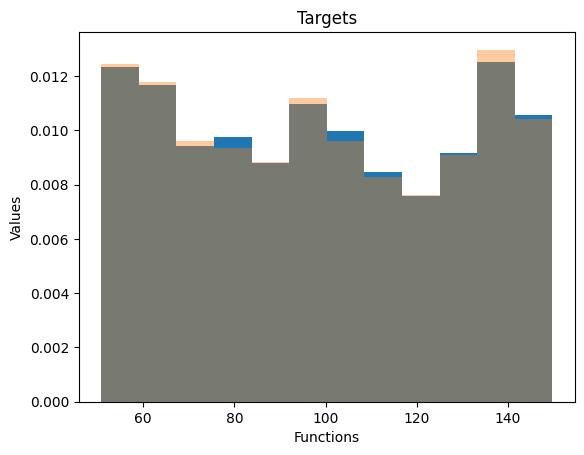

In [2]:
plt.hist(y_train, bins=12, density=True)
plt.hist(y_test, bins=12, density=True, alpha=0.4)
plt.title("Targets")
plt.xlabel("Functions")
plt.ylabel("Values")
plt.show()

Svar: Dette er et regresjonsproblem siden targets er kontinuerlige variabler.

# Oppgave 1.2 - lage en korrelasjonsmatrise

Fullfør funksjonen under slik at den tar inn både egenskapene og target, legger disse sammen i samme matrise igjen og visualiser dataene som en korrelasjonsmatrise (poenget er at du skal kunne se hvordan egenskapene korrelerer med target).




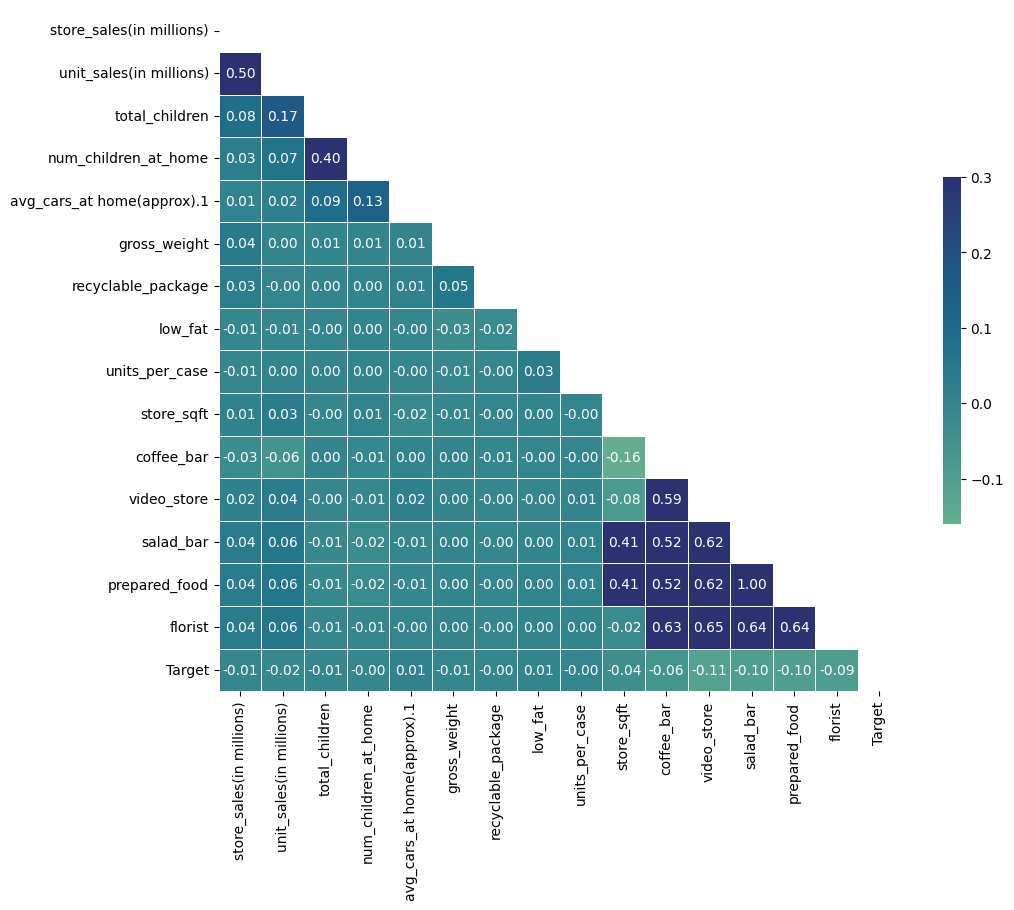

In [3]:
def correlation_matrix(X, y):
    X_temp = X.copy()
    y_temp = y.copy()
    # kombinerer target med data
    X_temp["Target"] = y_temp

    corr = X_temp.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # or choose a spesific cmap.
    cmap="crest"

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, fmt=".2f", cbar_kws={"shrink": .5})

correlation_matrix(X_train,y_train)

## Beskriv hvilke egenskaper du ser korrelerer mest med target
Svar: Korrelasjon defineres i område -1 til 1, og da er det sterk negativ og positiv korrelasjon. Er korrelasjonen 0, så er det ingen korrelasjon. I denne heatmap'en, er det ikke mange egenskaper som har sterk korrelasjon med target (cost), men den egenskapen som gir størst utslag er video_store som er på -0.11

# Oppgave 1.3 - gjør et strukturert hyperparametersøk
Velg en modellarkitektur (gjerne fra Scikit-Learn) og gjør et strukturert hyperparametersøk. 
* Gjør et søk på minst 3 paramtere og minst 2 verdier pr parameter
* Bruk 3-folds kryssvalidering for hver parameterkombinasjon
* Velg en metrikk som passer for målet (tips: "neg_mean_squared_error" i sklearn) 
* Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren. Kommenter resultatet

### Men først trener jeg en modell uten hyperparamter-optimalisering (du kan hoppe over denne)

In [4]:
# Viser hvordan en kan trene en LinearRegression model uten strukturert hyperparametersøk
regr = linear_model.LinearRegression() # bruker en del default parametere
regr.fit(X_train, y_train) # modellen trener på dataene.
y_pred = regr.predict(X_test) # modellen predikerer X_test, dette gir y_pred.

In [5]:
# Vi kan skrive ut de koeffisienten modellen har etter trening.
print("Coefficients: \n", regr.coef_)
# Vi kan regne modellens mean squared error. Verdier nær null viser til at modellen er nøyaktig.
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# Vi kan regne "The coefficient of determination". Hvis verdien er 1, så er modellen perfekt. Det er den ikke her.
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [ 4.92751551e-03 -2.43193712e-01 -1.55380688e-01 -8.03785258e-02
  3.80449661e-01 -3.50420472e-02 -2.54647997e-01  3.90149297e-01
  1.16286249e-03 -2.17260740e-04  5.34387211e-01 -6.36812705e+00
 -1.09738050e-01 -1.09738050e-01 -1.79392047e+00]
Mean squared error: 893.59
Coefficient of determination: 0.01


#### Vi skal nå se på hvordan vi kan forbedre modellen.

In [6]:
# her beregner vi kryssvalideringsskåren for modellen
# manuelt arbeid der vi selv velger hyperparameter og gjør en validering for å sjekke ytelsen.
# her prøver vi med to forskjellige hyperparameterkombinasjoner,regr2_a og regr2_b, og sjekker ytelsen.
regr2_a = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=-1, positive=True)
scores_a = cross_val_score(regr2_a, X_train, y_train, cv=3)
scores_a # returnerer valideringskåren for hver kryssvaliering

array([-2.55869851e-05, -2.75360816e-04, -1.13655670e-03])

In [7]:
# skriver ut nøyaktigheten og standardavviket for denne modellen
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_a.mean(), scores_a.std()))

-0.00 accuracy with a standard deviation of 0.00


In [8]:
# Bruker KFold med 3-folds som kryssvalidering. vi stokker om på dataene, psudorandom, så vi får samme omstokking hver gang.
kf = KFold(n_splits=3, shuffle=True, random_state=0) # gir oss mer kontroll over kryssvalideringen

regr2_b = linear_model.LinearRegression(fit_intercept=False, copy_X=True, n_jobs=None, positive=False)
scores_b = cross_val_score(regr2_b, X_train, y_train, cv=kf)
scores_b

array([-0.15957014, -0.15086972, -0.16035231])

In [9]:
# skriver ut nøyaktigheten og standardavviket for denne modellen
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_b.mean(), scores_b.std()))

-0.16 accuracy with a standard deviation of 0.00


Når vi skal finne de beste hyperparameterene er det bedre å bruke GridSearchCV (eventuelt RandomizedSearchCV).

## Nå skal vi gjøre et hyperparametersøk. Da velger vi å bruke GridSearchCV. Den gjør kryssvalidering basert på en parametergrid.

In [10]:
# Viser nå hvordan vi kan forbedre LinearRegression modellen ved å gjøre et strukturert hyperparametersøk.
# Hyperparametere er de parameter vi kan endre på. Vi kan bruke GridSearchCV til å finne de parameterene som gir modelle best score.
# Først lager vi parameter_grid som inneholder minst 3 parametere og 2 verdier per parameter, siden det er oppgitt i oppgaven.
# Disse er de mulige parameterene til LinearRegression: fit_intercept=True, copy_X=True, n_jobs=None, positive=False

In [11]:
# Vi skal finne de beste hyperparametere i denne parametergriden.
param_grid = [
    {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'n_jobs': [0, 1, -1],
        'positive': [True, False]
    }
]

# Vi lager en ny estimator med LinearRegression
regr3 = linear_model.LinearRegression()
# og bruker neg_mean_squared_error som metrikk
score = 'neg_mean_squared_error'

# Så bruker vi denne griden som et arguement i GridSearchV. I tillegg har GridSearchCV parameterene for estimatoren/modellen,
grid_search = GridSearchCV(
    regr3, param_grid=param_grid, scoring=score, cv=kf, verbose=1, return_train_score=True
)

In [12]:
# Nå trener vi på dataene for å finne de beste hyperparameterene.
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
             estimator=LinearRegression(),
             param_grid=[{'copy_X': [True, False],
                          'fit_intercept': [True, False], 'n_jobs': [0, 1, -1],
                          'positive': [True, False]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

### Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren. Kommenter resultatet

In [13]:
best_hyperparameters = grid_search.best_params_
best_score = grid_search.best_score_
print(f"De beste hyperparameterene for modellen er {best_hyperparameters}.\nModellens {score} er da {best_score}. Dette er modellens beste resultat i valideringen.")

De beste hyperparameterene for modellen er {'copy_X': True, 'fit_intercept': True, 'n_jobs': 0, 'positive': False}.
Modellens neg_mean_squared_error er da -886.3490788279172. Dette er modellens beste resultat i valideringen.


Kommentar til resultatet: neg_mean_squared_error viser hvor stor feil det er mellom predikerte og virkelige data.
En større negativ verdi vil si at modellen er bedre enn om den hadde mindre negativ verdi.

Det ser ut som den har valgt å tillate kopiering av data. Tenker at den unngår å jobbe direkte på dataene, men heller på kopien.

Det ser også ut som at den tillater å flytte på hvor funksjonenslinjen skal krysse y-aksen, hadde den vært satt til False, ville den krysset i origo.

Denne har valgt å ikke jobbe i parallel siden n_jobs er satt til 0. Den jobber med både positive og negative verdier fordi positive er satt til False.

Det som skjer når vi hyperparameter-tuner modellen, er at den tar regr3 estimatoren og kryssvaliderer med de hyperparametere som er definert i param_grid. Måten dette gjøres på bestemmes av kf som i dette tilfellet bestemmer å splitte treningsdatene i 3 folds. Når treningen er utført får vi tilbake den beste skåren og hyperparameterene som ble brukt. Skåren er gjennomsnittet av kryssvalideringene (eksempelvis kan dette observeres tydligere i forrige eksempel der vi brukte cross_val_score). Etter at vi har gjort hyperparametersøket kan vi bruke estimatoren med de beste hyperparameterne til å trene modellen på treningsdatene.

# Oppgave 1.4 - ny kryssvalidering og logging av metrikker

Bruk hyperparameterkombinasjonen fra oppgave 1.3 og kryssvalider den modellen på nytt med K >= 5

Logg "mean absolute error" og "mean squared error" for hver kryssvalideringsrunde
Oppgi gjennomsnitt og standardavvik for "mean absolute error" og "mean squared error" etter kryssvalideringen og kommenter resultatet. Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene?

In [14]:
# det vi fant ut i oppgave 1.3 om hyperparameterene og skåren.
print(f"De beste hyperparameterene for modellen er {best_hyperparameters}.\nModellens {score} er da {best_score}. Dette er modellens beste resultat i valideringen.")

De beste hyperparameterene for modellen er {'copy_X': True, 'fit_intercept': True, 'n_jobs': 0, 'positive': False}.
Modellens neg_mean_squared_error er da -886.3490788279172. Dette er modellens beste resultat i valideringen.


In [15]:
## vi oppdaterer kf sånn at K=9
#K=9
#kf = KFold(n_splits=K, shuffle=True, random_state=0)
#
## vi sette nå param_grid til kun å holde de hyperparameterene vi har valgt som de beste.
#param_grid = [
#    {
#        'fit_intercept': True,
#        'copy_X': True,
#        'n_jobs': 0,
#        'positive': False
#    }
#]
#
## kan sikkert skrive over regr3, men vi lager en ny estimator.
#regr4 = linear_model.LinearRegression()
#
## bruker neg_mean_squared_error som metrikk
#score = ['mean_squared_error', 'mean_absolute_error']
#
## Så bruker vi denne griden som et arguement i GridSearchV. I tillegg har GridSearchCV parameterene for estimatoren/modellen,
#grid_search = GridSearchCV(
#    regr3, param_grid=param_grid, scoring=score, cv=kf, verbose=4, return_train_score=True
#)

**Velger å finne en annen løsning enn GridSearchCV.** Tenker at vi kan prøve å bruke cross_val_score til å løse oppgaven.

## Utfør kryssvalidering med de optimale parameterene fra forrige oppgave og logg mean_absolute_error og mean_squared_error

In [16]:
K=9
kf = KFold(n_splits=K, shuffle=True, random_state=0)

# legger inn de beste hyperparameterene i estimatoren
optimal_regr = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=0, positive=False)
optimal_scores = cross_val_score(optimal_regr, X_train, y_train, cv=kf)
optimal_scores

array([0.01385616, 0.00968177, 0.01751084, 0.01525209, 0.01039366,
       0.02207111, 0.01747125, 0.01649708, 0.01182641])

In [17]:
print(np.mean(optimal_scores))

0.014951151504881478


In [18]:
print(np.std(optimal_scores))

0.003735375984430453


In [19]:
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error']
regr4 = linear_model.LinearRegression(fit_intercept=True, copy_X=True, n_jobs=0, positive=False)
scores = cross_validate(regr4, X_test, y_test, scoring=scoring)
sorted(scores.keys())
# fordi mean_squared_error ikke er støttet, kan vi gjøre et triks å multiplisere med -1
mean_squared_error = -1*scores['test_neg_mean_squared_error']
print(f"mean_squared_error: {mean_squared_error}")
mean_absolute_error = -1*scores['test_neg_mean_absolute_error']
print(f"mean_absolute_error: {mean_absolute_error}")


mean_squared_error: [890.18779197 902.65264067 881.40860098 881.17465051 918.36492166]
mean_absolute_error: [25.72328713 25.94436163 25.6328482  25.65588213 26.18047143]


## Oppgi gjennomsnitt og standardavvik for "mean absolute error" og "mean squared error" etter kryssvalideringen og kommenter resultatet

In [20]:
print("mean_squared_error:")
mse = np.mean(mean_squared_error).round(4)
std_deviation = np.std(mean_squared_error).round(4)
print(f"  Gjennomsnittet er {mse} og standardavviket er {std_deviation}")
print("mean_absolute_error:")
mae = np.mean(mean_absolute_error).round(4)
std_deviation = np.std(mean_absolute_error).round(4)
print(f"  Gjennomsnittet er {mae} og standardavviket er {std_deviation}")

mean_squared_error:
  Gjennomsnittet er 894.7577 og standardavviket er 14.1648
mean_absolute_error:
  Gjennomsnittet er 25.8274 og standardavviket er 0.2081


**Kommentar:**
Slik jeg forstår det er det sånn at en ønsker verdier fra mean_squared_error og mean_absolute_error nær null, da dette er en modell som predikere med stor nøyaktighet. Både cross_validate og GridSearchCV ikke støtter bruk av mean_squared_error og mean_absolute_error. Derfor kan en i enklere tilfeller bruke et triks der en multipliserer neg_mean_squared_error med -1 for å få mean_squared_error. Det er det jeg har gjort her. En bruker neg_mean_squared_error fordi konvensjonene er å si at en større verdier er bedre.

Gjennomsnittet for mean_squared_error er 894.76 med et standardavvik på 14.16. Standardavviket forteller oss hvor mye kostandene kan variere fra gjennomsnittet. Gjennomsnittet for mean_absolute_error er 25.83 med et standardavvik på 0.21.

mean_absolute_error forteller oss gjennomsnittet av avstanden fra alle punkter til funksjonslinjen vår.

mean_square_error forteller oss hvor stort areal disse feilene utgjør og er også basert på avstanden fra linjen. siden den regner i kvadratstørrelser er denne naturligvis større enn absolutt verdien.

Jeg tror mean_square_error er bedre til å oppdage "outlier" i datene enn mean_absolute_error. 

## Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene?

In [21]:
print(f"Gjennomnsnittlig feil på prediksjonen i forhold til target er {(mae/np.mean(y_train)*100).round(4)}%")

Gjennomnsnittlig feil på prediksjonen i forhold til target er 26.0%


Jeg synes feilen er litt for stor til å gjør gode prediksjoner.

## Oppgave 1.5 - Tren den optimale modellen og gjør prediksjon på testdata

Tren modellen en siste gang på alle treningsdataene og gjør prediksjon på testdataene (bruk de optimale parametrene fra oppgave 1.3)

In [22]:
# 'copy_X': True, 'fit_intercept': True, 'n_jobs': 0, 'positive': False
regr5 = linear_model.LinearRegression(copy_X = True, fit_intercept = True, n_jobs = 0, positive = False)

In [23]:
regr5.fit(X_train, y_train)

LinearRegression(n_jobs=0)

In [24]:
y_pred = regr5.predict(X_test)
y_pred

array([102.30294576,  94.73511503, 103.91270684, ..., 100.93182966,
       100.79482176, 100.84887096])

In [25]:
# Vi skal finne de beste hyperparametere i denne parametergriden.
param_grid = [
    {
        'fit_intercept': [True],
        'copy_X': [True],
        'n_jobs': [0],
        'positive': [False]
    }
]

# Vi lager en ny estimator med LinearRegression
final_regr = linear_model.LinearRegression()
# og bruker neg_mean_squared_error som metrikk
score = 'neg_mean_squared_error'

# Så bruker vi denne griden som et arguement i GridSearchV. I tillegg har GridSearchCV parameterene for estimatoren/modellen,
grid_search = GridSearchCV(
    final_regr, param_grid=param_grid, scoring=score, cv=kf, verbose=1, return_train_score=True
)

final_regr.fit(X_train, y_train)


LinearRegression()

In [26]:
y_pred_f = final_regr.predict(X_test)
y_pred_f

array([102.30294576,  94.73511503, 103.91270684, ..., 100.93182966,
       100.79482176, 100.84887096])

In [27]:
# refresh på pakken
from sklearn.metrics import mean_absolute_error
mean_absolute_error
mae_test = mean_absolute_error(y_test, y_pred)
mean_mae = mae_test/np.mean(y_test)

print(f"Gjennomsnittlig feil på prediksjonen sammenlignet med gjennomsnittlig virkelig pris er {mean_mae.round(2)*100}%")

Gjennomsnittlig feil på prediksjonen sammenlignet med gjennomsnittlig virkelig pris er 26.0%


**Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i testdataene?**

Treningsdata: Gjennomnsnittlig feil på prediksjonen i forhold til target er 26.0%

Testdata: Gjennomsnittlig feil på prediksjonen sammenlignet med gjennomsnittlig virkelig pris er 26.0%

Vi ønsker at de resultatet fra begge datasett skal være så like som mulig, og det er de her. Om resultatet fra treningsettet er bra, men med et dårlig resultat i testsettet, så er modellen "overfitted".